# Import Packages

In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
import tensorflow as tf
print(tf.__version__)


2.5.0


# Utility Functions

In [4]:
def plotSeries(time, series, format="-", start = 0, end = None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [5]:
def trend(time, slope=0 ):
    return slope* time

In [6]:
def seasonalPattern(seasonTime):
    return np.where(seasonTime < 0.4, np.cos(seasonTime * 2 * np.pi), 1/np.exp(3*seasonTime))

In [7]:
def seasonality(time, period, amplitude=1, phase=0):
    seasonTime = ((time + phase) % period) / period
    return amplitude * seasonalPattern(seasonTime)

In [8]:
def noise(time, noiseLevel = 1, seed=99):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noiseLevel


In [9]:
def windowDataset(series, windowSize, batchSize, shuffleBuffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(windowSize + 1, shift=1, drop_remainder = True)
    dataset = dataset.flat_map(lambda window: window.batch(windowSize + 1))
    dataset = dataset.shuffle(shuffleBuffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batchSize).prefetch(1)
    return dataset

# The Series

In [10]:
time = np.arange(4*365 + 1, dtype="float32")
baseline = 10
amplitude = 40
noiseLevel = 5
slope = 0.05

In [11]:
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude = amplitude)
series+= noise(time, noiseLevel)

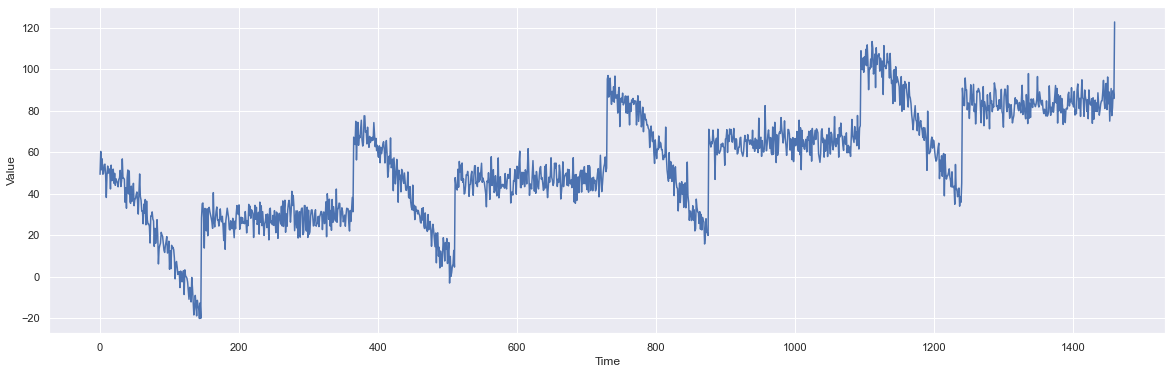

In [12]:
plt.figure(figsize=(20, 6))
plotSeries(time, series)
plt.show()

## The Split

In [13]:
splitTime = 1000
timeTrain = time[:splitTime]
xTrain = series[:splitTime]
timeValid = time[splitTime:]
xValid = series[splitTime:]

# Training Field

In [14]:
windowSize = 20
batchSize = 32
shuffleBufferSize = 1000

In [15]:
tf.keras.backend.clear_session()
tf.random.set_seed(99)

In [16]:
trainSet = windowDataset(xTrain, windowSize, batchSize, shuffleBufferSize)

## Model

In [17]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape = [None]),
    tf.keras.layers.SimpleRNN(40, return_sequences = True),
    tf.keras.layers.SimpleRNN(40),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*100.0)
])

In [18]:
lrSchedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch:1e-8*10**(epoch/20))
earlyStop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50, restore_best_weights=True)

In [19]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
             optimizer = optimizer,
             metrics = ["mae"])

In [20]:
history = model.fit(trainSet, epochs=500, callbacks=[lrSchedule, earlyStop])

Epoch 1/500
31/31 [==============================] - 14s 167ms/step - loss: 169.7708 - mae: 170.2708
Epoch 2/500
31/31 [==============================] - 4s 115ms/step - loss: 167.2803 - mae: 167.7803
Epoch 3/500
31/31 [==============================] - 4s 115ms/step - loss: 164.2507 - mae: 164.7507
Epoch 4/500
31/31 [==============================] - 4s 116ms/step - loss: 160.8407 - mae: 161.3407
Epoch 5/500
31/31 [==============================] - 4s 111ms/step - loss: 157.0181 - mae: 157.5181
Epoch 6/500
31/31 [==============================] - 4s 112ms/step - loss: 152.7499 - mae: 153.2499
Epoch 7/500
31/31 [==============================] - 4s 113ms/step - loss: 148.0014 - mae: 148.5014
Epoch 8/500
31/31 [==============================] - 4s 115ms/step - loss: 142.7178 - mae: 143.2178
Epoch 9/500
31/31 [==============================] - 4s 113ms/step - loss: 136.8782 - mae: 137.3782
Epoch 10/500
31/31 [==============================] - 4s 113ms/step - loss: 130.4324 - mae: 130.932

31/31 [==============================] - 4s 114ms/step - loss: 13.5223 - mae: 14.0153
Epoch 85/500
31/31 [==============================] - 4s 121ms/step - loss: 12.9226 - mae: 13.4152
Epoch 86/500
31/31 [==============================] - 4s 117ms/step - loss: 12.0904 - mae: 12.5825
Epoch 87/500
31/31 [==============================] - 4s 112ms/step - loss: 12.4781 - mae: 12.9712
Epoch 88/500
31/31 [==============================] - 4s 112ms/step - loss: 17.8137 - mae: 18.3075
Epoch 89/500
31/31 [==============================] - 4s 113ms/step - loss: 16.1596 - mae: 16.6548
Epoch 90/500
31/31 [==============================] - 4s 112ms/step - loss: 16.8176 - mae: 17.3137
Epoch 91/500
31/31 [==============================] - 4s 112ms/step - loss: 15.6609 - mae: 16.1530
Epoch 92/500
31/31 [==============================] - 4s 114ms/step - loss: 15.7640 - mae: 16.2594
Epoch 93/500
31/31 [==============================] - 4s 114ms/step - loss: 17.2737 - mae: 17.7690
Epoch 94/500
31/31 [===

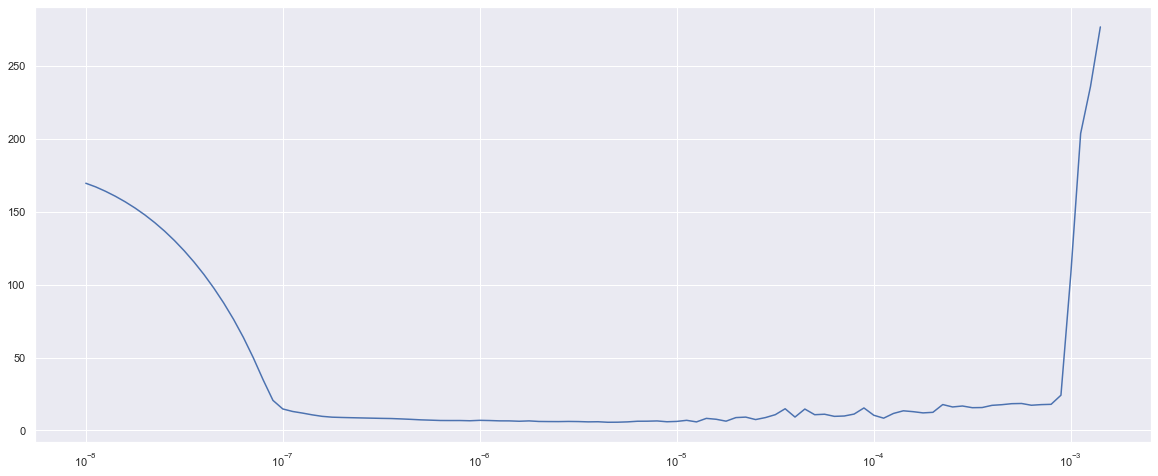

In [21]:
plt.figure(figsize=(20,8))
plt.semilogx(history.history["lr"], history.history["loss"])


In [22]:
forecast = []
for time in range(len(series) - windowSize):
    forecast.append(model.predict(series[time: time+windowSize][np.newaxis]))
    
forecast = forecast[splitTime-windowSize:]
results = np.array(forecast)[:, 0, 0]

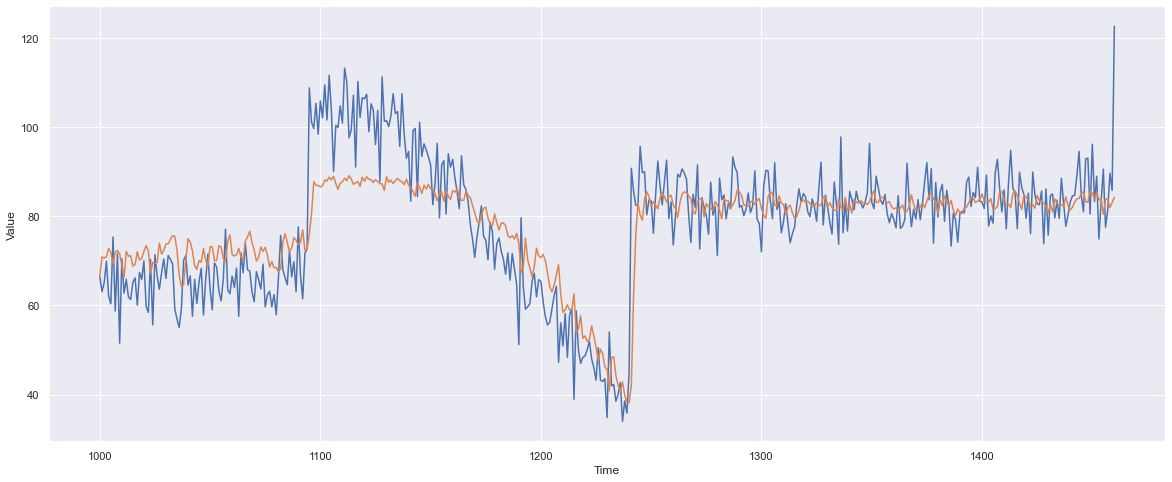

In [23]:
plt.figure(figsize=(20,8))
plotSeries(timeValid, xValid)
plotSeries(timeValid, results)